<a href="https://colab.research.google.com/github/Luc-cr/Prediccion_de_orientacion/blob/main/Prediccion_de_orientaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediccion De Orientaciones de ORT
### __OBJETIVO__: Crear una IA la cual sea capaz de recomendarte una orientacion


#### [Form](https://forms.gle/9im8DCpwdCJEigsj7)

# __IMPORTS__

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import uniform
import json

# __Data Extraction__

In [35]:
df = pd.read_csv('Cuestionario de orientaciones de ORT.csv') # Cargado de los datos
df.pop('Marca temporal') # No interesa
header = df.columns # Obtener las columnas
# Igualar los datos
#min = df['¿Cual es tu Orientación?'].value_counts()[-1]
'''
df = df.drop(df[(df[header[0]] == "TIC")].index[0:len(df[df[header[0]] == "TIC"].index)-min])
df = df.drop(df[(df[header[0]] == "Humanidades")].index[0:len(df[df[header[0]] == "Humanidades"].index)-min])
df = df.reset_index()
df
'''

'\ndf = df.drop(df[(df[header[0]] == "TIC")].index[0:len(df[df[header[0]] == "TIC"].index)-min])\ndf = df.drop(df[(df[header[0]] == "Humanidades")].index[0:len(df[df[header[0]] == "Humanidades"].index)-min])\ndf = df.reset_index()\ndf\n'

In [46]:
ori = {"Gestión": [uniform(0.9,1),uniform(0,0.3),uniform(0,0.3),uniform(0,0.3),uniform(0,0.3)], 
       "TIC": [uniform(0,0.3),uniform(0.9,1),uniform(0,0.3),uniform(0,0.3),uniform(0,0.3)], 
       "Medios":[uniform(0,0.3),uniform(0,0.3),uniform(0.9,1),uniform(0,0.3),uniform(0,0.3)], 
       "Humanidades":[uniform(0,0.3),uniform(0,0.3),uniform(0,0.3),uniform(0.9,1),uniform(0,0.3)], 
       "Diseño":[uniform(0,0.3),uniform(0,0.3),uniform(0,0.3),uniform(0,0.3),uniform(0.9,1)]}
def Convert_Matrix(num):# Convierte la data en un vector el cual va a funcionar como input
  y = np.asanyarray(ori[df[header[0]][num]])
  x = []

  for i in header[3:18]:
    x.append(float(df[i][num] / 5))

  for i in header[19:]:
    data = df[i][0]
  
    if data == 'Si':
      x.append(1.0)
    if data == 'No':
      x.append(0.0)
  
  return np.asarray(x)[np.newaxis],y

# __IA__ (LFlow)

In [37]:
class Functions():
  sigmoid = (lambda x: 1 / (1 + np.e ** (-x)),
        lambda x: x * (1 - x))
  relu = (lambda x: np.maximum(0,x),
        lambda x: (x > 0) * 1)
  f_error = (lambda x,y: np.mean((x-y)**2),
             lambda x,y: (x-y))
  tanh = (lambda x: (2/(1+ np.e **(-2*x)))-1,
        lambda x: 2/np.e ** x + np.e ** -x)
  umbral = lambda x: (x >0) * 1
  none = (lambda x: x, lambda x: 1)

In [38]:
class NeuralLayer():
  def __init__(self, connections, neurons, f_activ):
    self.f_activ = f_activ
    
    self.w = np.random.rand(connections, neurons)
    self.b = np.random.rand(1, neurons)
    
class NeuralLayer_load():
  def __init__(self, f_activ, w,b):
    self.f_activ = f_activ
    
    self.w = w
    self.b = b

In [39]:
class LF():
  def Create_NeuralNetwork(self, topology : tuple, f_activ : tuple) -> list:
    self.NN = []
    for i, layer in enumerate(topology[1:]):
      self.NN.append(NeuralLayer(topology[i], layer, f_activ[i]))
    return self.NN

  def Foward_Pass(self,x) -> list:
    self.out = [[None,x]]
    for i, layer in enumerate(self.NN):
      linear = self.out[i][1] @ layer.w + layer.b
      func = layer.f_activ[0](linear)
      self.out.append([linear, func])
    return self.out[-1][1]

  def Backward_Pass(self, y, lr: int) -> float:
    deltas = []
    for i in reversed(range(0,len(self.NN))):
      if i == len(self.NN) - 1:
        deltas.insert(0, Functions.f_error[1](self.out[-1][1], y) * self.NN[i].f_activ[1](self.out[-1][1]))
      else:
        deltas.insert(0, deltas[0] @ np.transpose(_w) * self.NN[i].f_activ[1](self.out[i + 1][1]))
      _w = self.NN[i].w
      

      self.NN[i].b = self.NN[i].b - np.mean(deltas[0]) * lr 
      self.NN[i].w = self.NN[i].w - self.out[i][1].T @ deltas[0] * lr
    
    return Functions.f_error[0](self.out[-1][1],y) 
  
  def Export_model(self, topology, f_active):
    model = {"topology" : topology, "f_active": f_active}
    for i, layer in enumerate(self.NN):
      model[i + 1] = {"weight": layer.w.tolist(), "bayes": layer.b.tolist()} 
    return json.dumps(model)
  
  def Import_model(self, file):
    funs = {"sigm": Functions.sigmoid, "relu": Functions.relu, "tanh": Functions.tanh, "umbral": Functions.umbral, "none": Functions.none}
    load = json.load(file)
    topology=load['topology']
    f_active=load['f_active']
    self.NN = []
    for i, layer in enumerate(topology[1:]):
      self.NN.append(NeuralLayer_load(funs[f_active[i]],load[str(i + 1)]['weight'],load[str(i + 1)]['bayes']))
    return self.NN

# __Codigo de la IA__

1.6225288063614095e-05


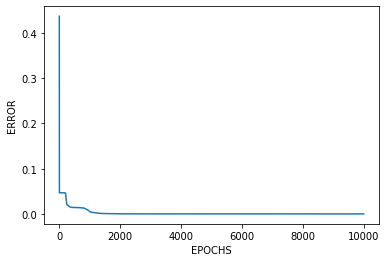

In [101]:
# IMPORTANTE
epochs = 10000 # Controla las veces que la inteligencia artificial va a repetirse

#--------
LFlow = LF()
z = 0
x = []
y = []
topology = [20,9,5] # El estilo de la Red Neuronal
f_layers = [Functions.sigmoid, Functions.sigmoid, Functions.sigmoid, Functions.sigmoid, Functions.sigmoid, Functions.sigmoid, Functions.sigmoid, Functions.sigmoid, Functions.sigmoid, Functions.sigmoid] # Las funciones de activacion que tienen cada capa
for i in range(0, df.shape[0]):
  x.append(Convert_Matrix(i)[0])
  y.append(Convert_Matrix(i)[1])
LFlow.Create_NeuralNetwork(topology, f_layers) # Creamos la red neuronal 
f_error = []
while z < epochs:
  error = []
  for i in range(0, df.shape[0]):
    LFlow.Foward_Pass(x[i])
    error.append(LFlow.Backward_Pass(y[i], 1))
  f_error.append(np.mean(error))
  z += 1
print(np.mean(error))
plt.plot(f_error)
plt.xlabel("EPOCHS")
plt.ylabel("ERROR")
plt.show()

# __Save Data__

In [103]:
z = 1
x,y = Convert_Matrix(z)
print(df['¿Cual es tu Orientación?'][z])
LFlow.Foward_Pass(x)

TIC


array([[0.25511638, 0.92538211, 0.04183553, 0.23721016, 0.13142031]])

In [104]:
file = open("NeuralNetwork.nn", "w")
file.write(LFlow.Export_model(topology,["sigm","sigm"]))
file.close()